# MSBD 5001 in-class project

**Description**
The dataset provides the average traffic speed per hour for a major road in Hong Kong from 2017 to 2018. Part of the dataset is provided as the training data, and your task is to predict the rest. 80% of the dataset is provided as the training data and 20% as the testing data, including the timestamp and the corresponding average speed. We sampled the testing data only from the year 2018 to provide you a training dataset that has the complete data spanning the year 2017. However, the speed information is sometimes missing due to device malfunction.

You have to submit the predicted results of these testing samples, which are then compared with the ground truth to evaluate the performance of your model.

In [1]:
"""     
Student Name:  ZHANG Xinyue
Student ID:    20750194
Assignment #:  kaggle in-class project
Student Email: xzhangfa@connect.ust.hk
Course Name:   MSBD5001
URL in github: 
"""

'     \nStudent Name:  ZHANG Xinyue\nStudent ID:    20750194\nAssignment #:  kaggle in-class project\nStudent Email: xzhangfa@connect.ust.hk\nCourse Name:   MSBD5001\nURL in github: \n'

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
from datetime import datetime, timedelta
from sklearn import metrics
from xgboost import plot_importance
from sklearn.model_selection import train_test_split,GridSearchCV
%matplotlib inline                                
#no need to do plt.show()

> ### 1.Loading data & show hist 

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
train.describe()                   #speed 32.779118 mean

,id,speed
count,14006.00000,14006.000000
mean,7002.50000,32.779118
std,4043.32827,13.573813
min,0.00000,2.573417
25%,3501.25000,19.301089
50%,7002.50000,36.580595
75%,10503.75000,45.877665
max,14005.00000,53.161286


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   date    14006 non-null  object 
 2   speed   14006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.4+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3504 non-null   int64 
 1   date    3504 non-null   object
dtypes: int64(1), object(1)
memory usage: 54.9+ KB


In [7]:
train.isnull().sum()   # no null

id       0
date     0
speed    0
dtype: int64

Text(0, 0.5, 'Frequency')

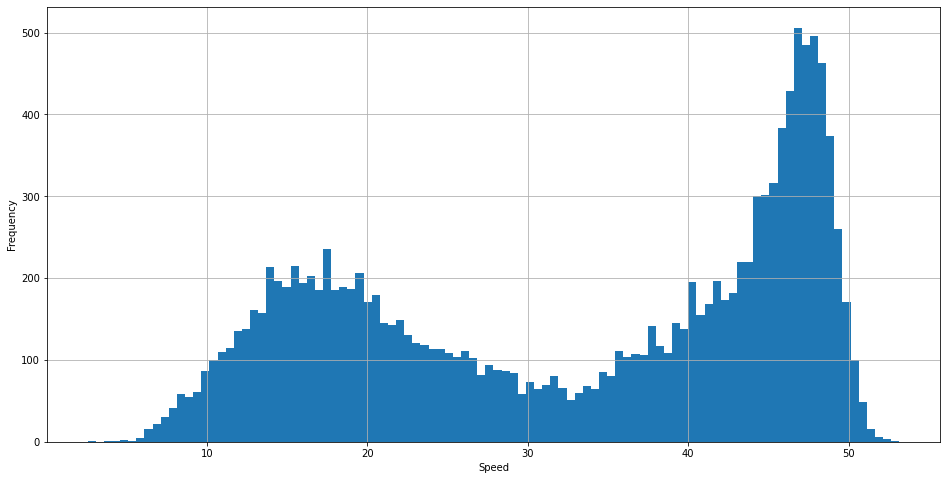

In [8]:
train.speed.hist(bins=100,figsize = (16,8))
plt.xlabel("Speed")
plt.ylabel("Frequency")

> ### 2.Trainning data preprocessing
**Problems:** 
* open train.csv, time is a type of string
* only one train.csv, no label
* Extract temporal features

| id       | date   |  speed  |
| --------   | -----:  | :----:  |
| 0      | 1/1/2017 0:00   |   43.002930     |
| 1        |  1/1/2017 1:00    |   46.1186969   |

In [9]:
train = pd.read_csv('./train.csv',parse_dates=['date'])
test = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
print( ' train shape:{}, columns:{} '.format(train.shape,train.columns))
print( ' test shape:{}, columns:{}'.format(test.shape,test.columns))

print(train['date'].head())
print(train.columns)


 train shape:(14006, 3), columns:Index(['id', 'date', 'speed'], dtype='object') 
 test shape:(3504, 1), columns:Index(['date'], dtype='object')
0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date, dtype: datetime64[ns]
Index(['id', 'date', 'speed'], dtype='object')


> ### 3.Feature engineering
**Methods** 
* encoder   2017-0  2018-1
* time transformation -> year+month+day+hr+weekday
* Hong Kong public holiday
* 1.https://www.gov.hk/tc/about/abouthk/holiday/2018.htm
  2.https://www.gov.hk/tc/about/abouthk/holiday/2017.htm
* weather information crawled from internet

In [10]:
weather = pd.read_csv('./weather.csv', parse_dates=['Time'])
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day

print(weather.head())

        Time  Weather  Wind  year  month  day
0 2018-01-01        0     8  2018      1    1
1 2018-01-02        0     8  2018      1    2
2 2018-01-03        0     8  2018      1    3
3 2018-01-04        1     8  2018      1    4
4 2018-01-05        0     0  2018      1    5


In [11]:
weather1=weather[['year','month','day','Wind']]
print(weather1.head())

   year  month  day  Wind
0  2018      1    1     8
1  2018      1    2     8
2  2018      1    3     8
3  2018      1    4     8
4  2018      1    5     0


In [12]:
#########year+month+day+he+weekday
for df in (train,test):
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day
    df['hr']    = df['date'].dt.hour
    df["weekday"] = df['date'].dt.weekday
#########year encoder
for df in (train,test):
    df['year1'] = np.nan 
    
    df.loc[(df.year==2017),'year1']= 0 
    df.loc[(df.year==2018),'year1']= 1 
#########早晚高峰
for df in (train,test):
    df['hr_categori'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 9)&(df.hr >= 7), 'hr_categori'] = "rush"   #工作日的早高峰7-9点
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 18)&(df.hr >= 16), 'hr_categori'] = "rush"  #工作日的晚高峰16-18点
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr < 16)&(df.hr > 9), 'hr_categori'] = "day"
    df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr < 7)|(df.hr > 18), 'hr_categori'] = "night"
    df.loc[(df.weekday >= 5)&(df.hr < 18)&(df.hr > 7), 'hr_categori'] = "day"                        #周末的白天
    df.loc[(df.weekday >= 5)&(df.hr <= 7)|(df.hr >= 18), 'hr_categori'] = "night"                    #周末的晚上
#########add 2017 2018 holiday
public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (train,test):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

#########season
season_dict = {
    3: 0, 4: 0, 5: 0,
    6: 1, 7: 1, 8: 1,
    9: 2, 10: 2, 11: 2,
    12: 3, 1: 3, 2: 3,}                     #0 spring     1  summer      2  fall       3  winter

for df in (train,test):
    df['season']=df['month'].map(season_dict)
    
#########weather
train = pd.merge(train, weather1, on = ['year','month', 'day'], how = 'left')
test = pd.merge(test, weather1, on = ['year','month', 'day'], how = 'left')

df_train = train.drop(columns= ['only-ymd','date','id'], axis= 1).copy()
df_test = test.drop(columns= ['only-ymd','date'], axis= 1).copy()
wind_train = pd.get_dummies(df_train['Wind'], prefix='w', prefix_sep='_')
wind_test = pd.get_dummies(df_test['Wind'], prefix='w', prefix_sep='_') 

df_train.drop(['Wind'],axis = 1)
df_test.drop(['Wind'],axis = 1)

df_train = pd.concat([df_train,wind_train], axis=1)

df_test = pd.concat([df_test,wind_test], axis=1)

df_train=df_train.drop(['year'],axis=1)
df_test=df_test.drop(['year'],axis=1)

df_train


,speed,month,day,hr,weekday,year1,hr_categori,y/n-holiday,season,Wind,...,w_2,w_3,w_5,w_6,w_7,w_8,w_10,w_12,w_14,w_16
0,43.002930,1,1,0,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
1,46.118696,1,1,1,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
2,44.294158,1,1,2,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
3,41.067468,1,1,3,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
4,46.448653,1,1,4,6,0.0,night,0,3,6,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,19.865269,12,31,12,0,1.0,day,0,3,5,...,0,0,1,0,0,0,0,0,0,0
14002,17.820375,12,31,15,0,1.0,day,0,3,5,...,0,0,1,0,0,0,0,0,0,0
14003,12.501851,12,31,16,0,1.0,rush,0,3,5,...,0,0,1,0,0,0,0,0,0,0
14004,15.979319,12,31,18,0,1.0,night,0,3,5,...,0,0,1,0,0,0,0,0,0,0


In [13]:
df_train.corr()['speed']       #weekday        0.115887 

speed          1.000000
month         -0.028827
day           -0.019485
hr            -0.390044
weekday        0.115887
year1          0.015102
y/n-holiday    0.055386
season         0.014134
Wind           0.030279
w_0           -0.020286
w_2            0.007465
w_3           -0.005268
w_5           -0.002846
w_6           -0.008172
w_7            0.007959
w_8            0.020017
w_10           0.014795
w_12           0.024941
w_14           0.027469
w_16           0.016915
Name: speed, dtype: float64

> ### 4.Feature engineering adjusted
**Methods** 
* less builtin-function - i found the result will be diff
* time transformation -> year+month+day+hr+weekdayindex
* Hong Kong public holiday
* 1.https://www.gov.hk/tc/about/abouthk/holiday/2018.htm
  2.https://www.gov.hk/tc/about/abouthk/holiday/2017.htm
* Wind corr score too slow and one-hot encoder causes more zero in one row  -> delete
* GridSearchCV
* xgb.train
* write to csv

In [37]:
df = pd.read_csv("train.csv")
df["time"] = df["date"].apply(lambda x : int(x[-5:-3]))
df["day"] = df["date"].apply(lambda x : int(x.split('/')[0]))
df["month"] = df["date"].apply(lambda x : int(x.split('/')[1]))
df["year"] = df["date"].apply(lambda x : int(x.split('/')[2][0:4]))
df.drop(["date"], axis = 1, inplace=True)
df.drop(["id"], axis = 1, inplace=True)
ydata = df["speed"]
xdata = df[["time", "day", "month"]]
xdata['year'] = 0
xdata['year'].iloc[8750:14006] = 1
day = df["day"]
weekend = [7]
dayindex = 1
for i in range(1, len(day)):
    if int(day[i-1]) == int(day[i]):
        weekend.append(weekend[-1])
    else:
        dayindex += 1
        if dayindex%7 == 2:
            weekend.append(1)
        elif dayindex%7 == 3:
            weekend.append(2)
        elif dayindex%7 == 4:
            weekend.append(3)
        elif dayindex%7 == 5:
            weekend.append(4)
        elif dayindex%7 == 6:
            weekend.append(5)
        elif dayindex%7 == 0:
            weekend.append(6)
        else: weekend.append(7)
xdata["weekend"] = weekend
dft = pd.read_csv("test.csv")
dft["time"] = dft["date"].apply(lambda x : int(x[-5:-3]))
dft["day"] = dft["date"].apply(lambda x : int(x.split('/')[0]))
dft["month"] = dft["date"].apply(lambda x : int(x.split('/')[1]))
dft["year"] = dft["date"].apply(lambda x : int(x.split('/')[2][0:4]))
dayt = dft["day"]
dft.drop(["date"], axis = 1, inplace=True)
dft.drop(["id"], axis = 1, inplace=True)
xtest = dft[["time", "day", "month"]]  #, 'spring', 'summer', 'autumn', 'winter'
xtest['year'] = 1
weekendt = [1]
daytindex = 1
for i in range(1, len(dayt)):
    if int(dayt[i-1]) == int(dayt[i]):
        weekendt.append(weekendt[-1])
    else:
        daytindex += 1
        if daytindex%7 == 1:
            weekendt.append(1)
        elif daytindex%7 == 2:
            weekendt.append(2)
        elif daytindex%7 == 3:
            weekendt.append(3)
        elif daytindex%7 == 4:
            weekendt.append(4)
        elif daytindex%7 == 5:
            weekendt.append(5)
        elif daytindex%7 == 6:
            weekendt.append(6)
        else: weekendt.append(7)
xtest["weekend"] = weekendt
x1_train=xdata
x1_test=xtest

<ipython-input-37-5c1d8a326f74>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdata['year'] = 0
<ipython-input-37-5c1d8a326f74>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdata['year'].iloc[8750:14006] = 1


In [38]:
x1_train

,time,day,month,year,weekend
0,0,1,1,0,7
1,1,1,1,0,7
2,2,1,1,0,7
3,3,1,1,0,7
4,4,1,1,0,7
...,...,...,...,...,...
14001,12,31,12,1,1
14002,15,31,12,1,1
14003,16,31,12,1,1
14004,18,31,12,1,1


In [39]:
x1_test

,time,day,month,year,weekend
0,2,1,1,1,1
1,5,1,1,1,1
2,7,1,1,1,1
3,8,1,1,1,1
4,10,1,1,1,1
...,...,...,...,...,...
3499,17,31,12,1,1
3500,19,31,12,1,1
3501,21,31,12,1,1
3502,22,31,12,1,1


In [40]:
traindate = pd.read_csv('./train.csv',parse_dates=['date'])
testdate = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
trdate=traindate['date']
tedate=testdate['date']
xd=pd.concat([x1_train,trdate], axis=1)
xt=pd.concat([x1_test,tedate], axis=1)
xt

,time,day,month,year,weekend,date
0,2,1,1,1,1,2018-01-01 02:00:00
1,5,1,1,1,1,2018-01-01 05:00:00
2,7,1,1,1,1,2018-01-01 07:00:00
3,8,1,1,1,1,2018-01-01 08:00:00
4,10,1,1,1,1,2018-01-01 10:00:00
...,...,...,...,...,...,...
3499,17,31,12,1,1,2018-12-31 17:00:00
3500,19,31,12,1,1,2018-12-31 19:00:00
3501,21,31,12,1,1,2018-12-31 21:00:00
3502,22,31,12,1,1,2018-12-31 22:00:00


In [41]:
xd

,time,day,month,year,weekend,date
0,0,1,1,0,7,2017-01-01 00:00:00
1,1,1,1,0,7,2017-01-01 01:00:00
2,2,1,1,0,7,2017-01-01 02:00:00
3,3,1,1,0,7,2017-01-01 03:00:00
4,4,1,1,0,7,2017-01-01 04:00:00
...,...,...,...,...,...,...
14001,12,31,12,1,1,2018-12-31 12:00:00
14002,15,31,12,1,1,2018-12-31 15:00:00
14003,16,31,12,1,1,2018-12-31 16:00:00
14004,18,31,12,1,1,2018-12-31 18:00:00


In [51]:
####  add public holiday
public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (xd,xt):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

In [52]:
x1_train=xd.drop(['date','only-ymd'],axis=1)
x1_test=xt.drop(['date','only-ymd'],axis=1)

In [53]:
for df in (x1_train,x1_test):
    df['y/n-weekday'] = np.nan 
    df.loc[(df.weekend>=6),'y/n-weekday']=int(1)  #周末为1
    df.loc[(df.weekend<=5),'y/n-weekday']=int(0)  #工作日为0

In [54]:
x1_train

,time,day,month,year,weekend,y/n-holiday,y/n-weekday
0,0,1,1,0,7,0,1.0
1,1,1,1,0,7,0,1.0
2,2,1,1,0,7,0,1.0
3,3,1,1,0,7,0,1.0
4,4,1,1,0,7,0,1.0
...,...,...,...,...,...,...,...
14001,12,31,12,1,1,0,0.0
14002,15,31,12,1,1,0,0.0
14003,16,31,12,1,1,0,0.0
14004,18,31,12,1,1,0,0.0


In [58]:
x_train, x_test, y_train, y_test = train_test_split(x1_train, ydata, test_size=0.2, random_state=1)
pa = {'booster': 'gbtree','objective': 'reg:squarederror','gamma': 0,'max_depth': 45,'lambda': 3,'subsample': 0.5,'colsample_bytree': 1,'min_child_weight': 0,'silent': 0,'eta': 0.01,'seed': 1000,'nthread': 4,'reg_alpha': 0,}
dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_test, y_test)
p = list(pa.items())
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(p, dtrain,850,watchlist)
predict_y_train = model.predict(xgb.DMatrix(x_train))
predict_y_test = model.predict(xgb.DMatrix(x_test))

print("train:",metrics.mean_squared_error(y_train, predict_y_train))
print("test:",metrics.mean_squared_error(y_test, predict_y_test))

[10:58:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:34.68335	valid-rmse:34.63907
[1]	train-rmse:34.34393	valid-rmse:34.29872
[2]	train-rmse:34.00783	valid-rmse:33.96142
[3]	train-rmse:33.67581	valid-rmse:33.62826
[4]	train-rmse:33.34676	valid-rmse:33.29814
[5]	train-rmse:33.02078	valid-rmse:32.97131
[6]	train-rmse:32.69843	valid-rmse:32.64766
[7]	train-rmse:32.37944	valid-rmse:32.32790
[8]	train-rmse:32.06263	valid-rmse:32.01031
[9]	train-rmse:31.75043	valid-rmse:31.69727
[10]	train-rmse:31.44101	valid-rmse:31.38690
[11]	train-rmse:31.13522	valid-rmse:31.07998
[12]	train-rmse:30.83199	valid-rmse:30.77586
[13]	train-rmse:30.53200	valid-rmse:30.47507
[14]	train-rmse:30.23493

[175]	train-rmse:7.16997	valid-rmse:7.20824
[176]	train-rmse:7.11625	valid-rmse:7.15721
[177]	train-rmse:7.06414	valid-rmse:7.10741
[178]	train-rmse:7.01259	valid-rmse:7.05755
[179]	train-rmse:6.96129	valid-rmse:7.00927
[180]	train-rmse:6.91037	valid-rmse:6.96068
[181]	train-rmse:6.86021	valid-rmse:6.91296
[182]	train-rmse:6.81034	valid-rmse:6.86585
[183]	train-rmse:6.76122	valid-rmse:6.81848
[184]	train-rmse:6.71289	valid-rmse:6.77233
[185]	train-rmse:6.66452	valid-rmse:6.72662
[186]	train-rmse:6.61636	valid-rmse:6.68142
[187]	train-rmse:6.56886	valid-rmse:6.63651
[188]	train-rmse:6.52227	valid-rmse:6.59320
[189]	train-rmse:6.47542	valid-rmse:6.54919
[190]	train-rmse:6.42984	valid-rmse:6.50679
[191]	train-rmse:6.38411	valid-rmse:6.46384
[192]	train-rmse:6.33949	valid-rmse:6.42200
[193]	train-rmse:6.29512	valid-rmse:6.38127
[194]	train-rmse:6.25193	valid-rmse:6.34079
[195]	train-rmse:6.20786	valid-rmse:6.29964
[196]	train-rmse:6.16470	valid-rmse:6.26015
[197]	train-rmse:6.12216	valid-r

[362]	train-rmse:2.84986	valid-rmse:3.65268
[363]	train-rmse:2.84142	valid-rmse:3.64840
[364]	train-rmse:2.83316	valid-rmse:3.64539
[365]	train-rmse:2.82484	valid-rmse:3.64126
[366]	train-rmse:2.81658	valid-rmse:3.63760
[367]	train-rmse:2.80887	valid-rmse:3.63367
[368]	train-rmse:2.80096	valid-rmse:3.62961
[369]	train-rmse:2.79273	valid-rmse:3.62560
[370]	train-rmse:2.78513	valid-rmse:3.62185
[371]	train-rmse:2.77743	valid-rmse:3.61875
[372]	train-rmse:2.76984	valid-rmse:3.61493
[373]	train-rmse:2.76188	valid-rmse:3.61106
[374]	train-rmse:2.75422	valid-rmse:3.60753
[375]	train-rmse:2.74681	valid-rmse:3.60392
[376]	train-rmse:2.73907	valid-rmse:3.60049
[377]	train-rmse:2.73121	valid-rmse:3.59691
[378]	train-rmse:2.72312	valid-rmse:3.59322
[379]	train-rmse:2.71571	valid-rmse:3.59011
[380]	train-rmse:2.70853	valid-rmse:3.58673
[381]	train-rmse:2.70126	valid-rmse:3.58338
[382]	train-rmse:2.69392	valid-rmse:3.58019
[383]	train-rmse:2.68693	valid-rmse:3.57695
[384]	train-rmse:2.67975	valid-r

[549]	train-rmse:1.89706	valid-rmse:3.33856
[550]	train-rmse:1.89410	valid-rmse:3.33817
[551]	train-rmse:1.89085	valid-rmse:3.33729
[552]	train-rmse:1.88752	valid-rmse:3.33677
[553]	train-rmse:1.88442	valid-rmse:3.33647
[554]	train-rmse:1.88117	valid-rmse:3.33565
[555]	train-rmse:1.87787	valid-rmse:3.33541
[556]	train-rmse:1.87467	valid-rmse:3.33479
[557]	train-rmse:1.87143	valid-rmse:3.33402
[558]	train-rmse:1.86841	valid-rmse:3.33351
[559]	train-rmse:1.86520	valid-rmse:3.33267
[560]	train-rmse:1.86213	valid-rmse:3.33209
[561]	train-rmse:1.85896	valid-rmse:3.33138
[562]	train-rmse:1.85570	valid-rmse:3.33062
[563]	train-rmse:1.85263	valid-rmse:3.33050
[564]	train-rmse:1.84947	valid-rmse:3.33036
[565]	train-rmse:1.84626	valid-rmse:3.33033
[566]	train-rmse:1.84321	valid-rmse:3.32986
[567]	train-rmse:1.84002	valid-rmse:3.32930
[568]	train-rmse:1.83671	valid-rmse:3.32867
[569]	train-rmse:1.83365	valid-rmse:3.32818
[570]	train-rmse:1.83058	valid-rmse:3.32736
[571]	train-rmse:1.82743	valid-r

[736]	train-rmse:1.42706	valid-rmse:3.29193
[737]	train-rmse:1.42514	valid-rmse:3.29176
[738]	train-rmse:1.42315	valid-rmse:3.29178
[739]	train-rmse:1.42119	valid-rmse:3.29147
[740]	train-rmse:1.41931	valid-rmse:3.29143
[741]	train-rmse:1.41743	valid-rmse:3.29143
[742]	train-rmse:1.41551	valid-rmse:3.29144
[743]	train-rmse:1.41355	valid-rmse:3.29123
[744]	train-rmse:1.41162	valid-rmse:3.29154
[745]	train-rmse:1.40973	valid-rmse:3.29150
[746]	train-rmse:1.40773	valid-rmse:3.29139
[747]	train-rmse:1.40589	valid-rmse:3.29152
[748]	train-rmse:1.40401	valid-rmse:3.29135
[749]	train-rmse:1.40212	valid-rmse:3.29122
[750]	train-rmse:1.40033	valid-rmse:3.29117
[751]	train-rmse:1.39832	valid-rmse:3.29123
[752]	train-rmse:1.39650	valid-rmse:3.29107
[753]	train-rmse:1.39449	valid-rmse:3.29099
[754]	train-rmse:1.39263	valid-rmse:3.29096
[755]	train-rmse:1.39083	valid-rmse:3.29120
[756]	train-rmse:1.38902	valid-rmse:3.29124
[757]	train-rmse:1.38723	valid-rmse:3.29119
[758]	train-rmse:1.38532	valid-r

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

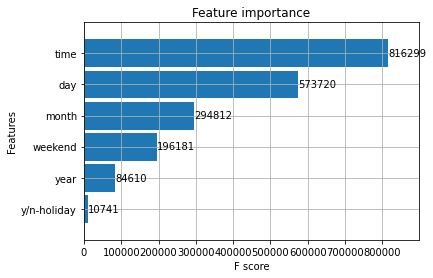

In [56]:
fscores = model.get_fscore()
#top_50_list = sorted(fscores, key=fscores.get, reverse=True)[:50]
#比如获得前50个特征的排序

xgb.plot_importance(model, max_num_features=20, height=0.9)
#前20特征值绘制条状图

In [59]:
pred = model.predict(xgb.DMatrix(x1_test))
pred

array([48.43782 , 47.896225, 37.013554, ..., 45.785896, 40.85208 ,
       41.642357], dtype=float32)

In [60]:
result = pd.DataFrame({"id":range(3504), "speed":pred})
result.to_csv("submission10.83.csv", index=False)